## <div align='center'><b>Feature Importance in Machine Learning</b></div>

### <div align='center'>Ensun Pak</div>

In [2]:
# Import packages
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina' 

### <b>1 - Introduction to Feature Importance in Machine Learning</b>
Feature importance selection is a technique used in machine learning and statistical modelling. The goal of feature selection is to determine which feature in a model is the most relevant. In other words, we are only interested to know which features in our model can explain the most variation in the data. Feature importance is not to be mistaken with feature extraction, where the latter deals with creating new features from existing ones[1]. There are benefits to performing feature importance analysis on a dataset that we are interested to work on. Excluding redundant features will help speed up the machine learning algorithm, reduces the complexity of the model making it more interpretable and it can also possibly reduce the risk of overfitting in the model[2].

When we are dealing with datasets that have a large number of features, it usually affects our processing cost and it is something that we should optimize where possible.

There are many methods to perform feature importance, we will be discussing some of these methods in this article. In the second half of this article two case studies on two different sample datasets will be used to show the implementation and effectiveness of the methods discussed so far. There are three main categories of feature selection algorithms:

- Wrapper methods
- Filter methods
- Embedded methods

#### 1.1 - Wrapper methods
Wrapper methods consist of using a predictive machine learning model to score subsets of the features that is found in the original dataset. This is usually done in an iterative process, where once one subset has been fitted and scored, the next subset will be fitted and subsequently scored. The process will end when all possible permutations of the features are scored[3]. Some common techniques under wrapper methods are:

- Forward selection
- Backward selection
- Step-wise selection

This approach can be very computationally intensive thus this needs to be factored in when designing a machine learning strategy to solve a problem. 

#### 1.2 - Filter methods
Filter methods generally tries to identify the importance of features through their statistical values. As an example, the correlation of a feature to the target variable offers insights into the feature importance of a dataset that we are working on. Here are some common techniques that can be found under filter methods:

- Correlation based (Pearson's / Spearman's rank)
- Variance thresholding
- Chi-squared test
- Mutual information

Filter methods are generally very computationally efficient and can handle large datasets very well. However, they do not take into account the interactions that occur between features, and so may not select the optimal features. These methods are usually used complementarily with other feature importance analysis techniques so we can get stronger results.

#### 1.3 - Embedded methods
In embedded methods, the feature selection process is embedded into the learning of an algorithm during the model development phase. This set of feature selection algorithms are often ranked between wrapper and filter methods[4]. Some techniques in embedded methods are:

- LASSO (L1 regularization)
- Ridge (L2 regularization)
- ElasticNet (L1 and L2 regularization)

Embedded methods are more computationally intensive than filter methods, and they are usually more relevant to contribute to the feature selection process on the model being trained.

#### 1.4 - Comparison of the feature selection methods
<img src='https://1.bp.blogspot.com/-9nTW9y5oG3s/XbFL-bQzgbI/AAAAAAAABWk/Cys_uTBUhvgDIDtgwwmR56QrHZaA_ygfACLcBGAsYHQ/s1600/4a.PNG'>

From the above table[4], it is worth noting that selecting a proper feature selection technique is not straightforward, and there is no one algorithm that can solve all types of modelling challenges. Therefore, selecting one needs careful consideration of the type of data being trained on. Having said that, it is also possible to combine several algorithms to get more robust results in feature reduction.

### <b>2 - Case Study</b>
In this section of the article, we will go through two case studies to showcase the feature importance selection algorithms. One case study will focus on a classification model, while the other a regression model.

#### 2.1 - Feature importance for classfication problems

In [2]:
# Load sample bankruptcy dataset sourced from UCI Machine Learning Repository.
# https://archive.ics.uci.edu/ml/datasets/student+performance
df = pd.read_csv('./student/student-mat.csv', delimiter=';')
to_encode = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob',
             'Fjob', 'reason', 'guardian','schoolsup', 'famsup', 'paid',
             'activities', 'nursery', 'higher', 'internet', 'romantic']

# Label encode categorical features.
for col in to_encode:
    df[col + '_enc'] = LabelEncoder().fit_transform(df[col])
    df.drop([col], axis=1, inplace=True)

We will use this dataset that has 33 features and fit a model to predict the higher label. The dataset has a lot of categorical features, and these have been label encoded so the package can properly take the data as inputs. Following the baseline model accuracy, we will employ some feature selection techniques and finally compare and review if there is any improvement in the accuracy of the models with lesser features.

In [3]:
# Setup train/test datasets
X = df.drop('higher_enc', axis=1)
Y = df['higher_enc']
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.2, 
                                                    shuffle=False,
                                                    random_state=1)

# Fit the model
clf = LogisticRegression(solver='liblinear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)
print(f"Classification accuracy: {accuracy_score(y_train, y_pred):.3%}")

Classification accuracy: 97.152%


#### 2.1.1 - Variance Threshold (Filter Method)
First we will use the variance threshold and configure it in such a way to to identify any quasi-constant features in the dataset that would not add much information into the model. The intuition is any feature that is a constant, or close to being a constant does not add any information to the model. These should be excluded.

To do this, the threshold of 1% is used to denote 99% of observations in the dataset.

In [4]:
# Use variance treshold from filter methods to remove redundant features
selector = VarianceThreshold(threshold=0.1)
selector.fit(X)
X_r = selector.transform(X)
X_r.shape

(395, 31)

In [5]:
# Refit the model with the reduced dataset to evaluate validation performance
x_train, x_test, y_train, y_test = train_test_split(X_r, Y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# Fit the model
clf = LogisticRegression(solver='liblinear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)
print(f"Classification accuracy: {accuracy_score(y_train, y_pred):.3%}")

Classification accuracy: 97.152%


Variance threshold identified that only one of the feature was a quasi-constant. Removing the features and then refitting the model did not decrease the accuracy score. This method is very dependent on the type of dataset we are working with. If the dataset has many features that have no variation, then we would expect more features to be dropped.

#### 2.1.2 - Select KBest Features (Filter Method)
This method uses the $\chi^2$ test to measure the highest score for each K

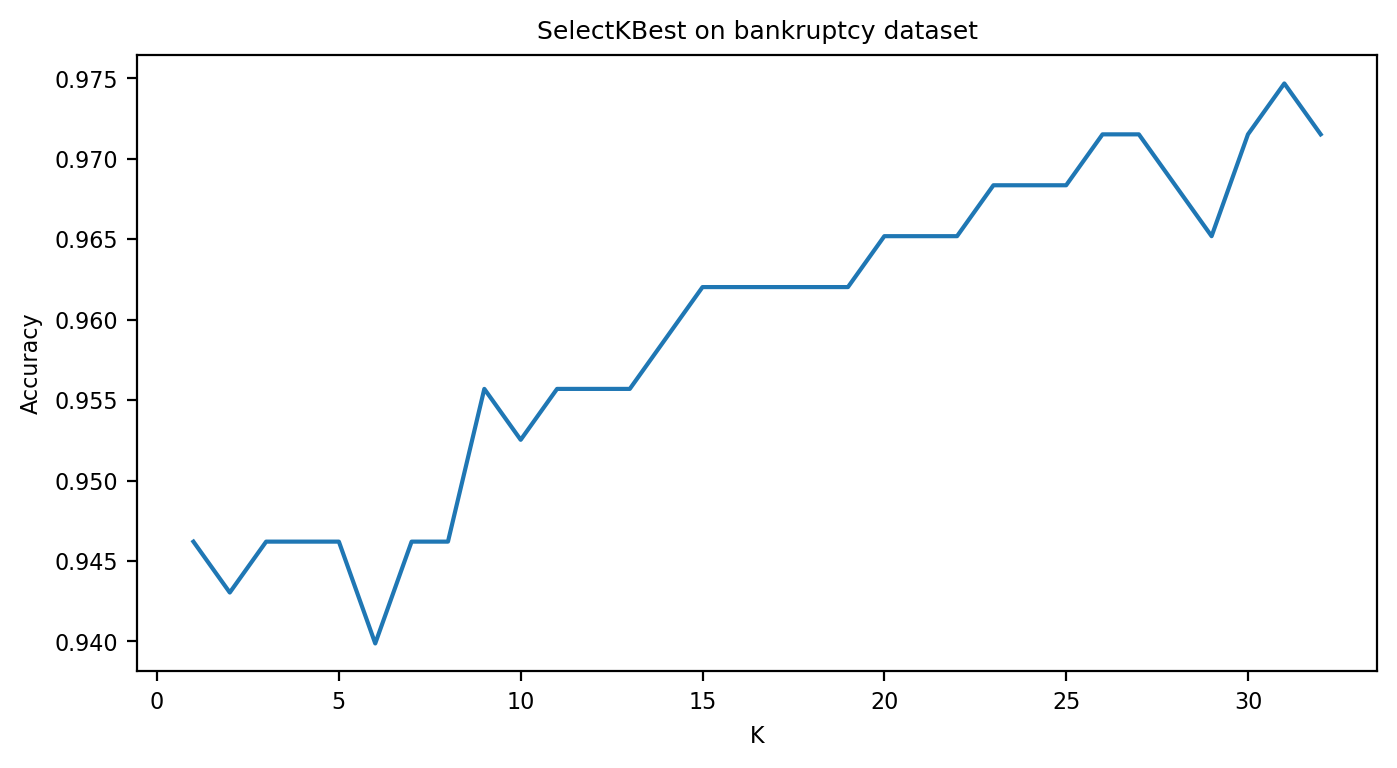

In [6]:
# Loop to go through k parameters for SelectKBest
k_list = [i for i in range(1, 33)]
acc = []
for k in k_list:
    selector = SelectKBest(chi2, k=k)
    selector.fit(X, Y)
    X_r = selector.transform(X)
    X_r.shape

    # Refit the model with the reduced dataset to evaluate validation performance
    x_train, x_test, y_train, y_test = train_test_split(X_r, Y,
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=1)

    # Fit model
    clf = LogisticRegression(solver='liblinear')
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)
    acc.append(accuracy_score(y_train, y_pred))

# Construct plot
plt.figure(figsize=(8,4))
plt.plot(k_list, acc)
plt.title('SelectKBest on bankruptcy dataset', fontsize=9)
plt.tick_params(labelsize=8)
plt.ylabel('Accuracy', fontsize=8)
plt.xlabel('K', fontsize=8)
plt.show()

From the plot, we have an interesting problem. We can see that as we begin to discard more features, we can see the accuracy detetriorate. However, this is a trade-off issue where while selecting a model with lesser features can lower the complexity of the final model, there is some compromise on the accuracy. Let's see what the $\chi^2$ score for the 15 features of this model.

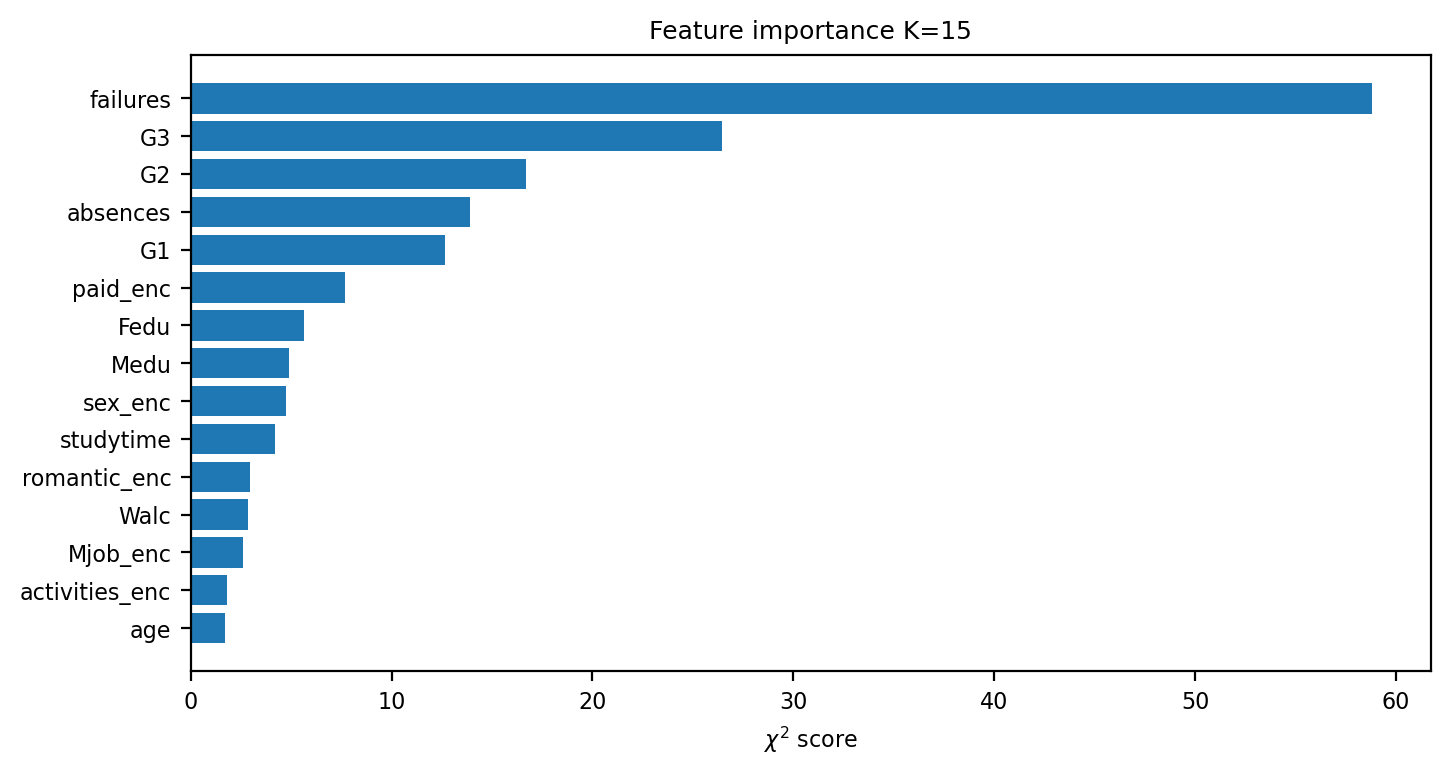

In [7]:
# Run SelectKBest
selector = SelectKBest(chi2, k=15)
selector.fit(X, Y)
filter = selector.get_support()
feat_imp = pd.DataFrame({'features': X.columns[filter],
                         'chi2_score' : selector.scores_[filter]})\
    .sort_values('chi2_score')\
        .reset_index(drop=True)

# Construct plot
plt.figure(figsize=(8, 4))
plt.barh(feat_imp['features'], feat_imp['chi2_score'])
plt.title('Feature importance K=15', fontsize=9)
plt.xlabel(r'$\chi^2$ score', fontsize=8)
plt.tick_params(labelsize=8)
plt.show()

In [8]:
# Refit the model with the reduced dataset to evaluate validation performance
X_r = selector.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X_r, Y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# Fit model
clf = LogisticRegression(solver='liblinear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)
print(f"Classification accuracy: {accuracy_score(y_train, y_pred):.3%}")

Classification accuracy: 96.203%


In this case study, by selecting k=15, we gained a reduction of 50% features in our model for a compromise of 1.3% loss on the model accuracy, which is not a bad deal!

#### 2.1.3 - Step Forward Feature Selection  (Wrapper Method)
We have seen some filtering methods in action on our bankruptcy dataset. Let's take a look at forward feature selection under wrapper feature importance methods. This method takes an iterative process and fits a model based on different permutations of the features.

In [9]:
# Create a sequential feature selector object
sfs = SequentialFeatureSelector(LogisticRegression(solver='liblinear'),
                                scoring='accuracy',
                                direction='forward',
                                n_features_to_select='warn')
sfs.fit(X, Y)

# Get feature names
sfs.get_feature_names_out()

/Users/ensun.pak/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_sequential.py:188: FutureWarning: Leaving `n_features_to_select` to None is deprecated in 1.0 and will become 'auto' in 1.3. To keep the same behaviour as with None (i.e. select half of the features) and avoid this warning, you should manually set `n_features_to_select='auto'` and set tol=None when creating an instance.
  warnings.warn(


array(['age', 'Medu', 'Fedu', 'traveltime', 'failures', 'famrel',
       'freetime', 'goout', 'health', 'absences', 'G2', 'school_enc',
       'Pstatus_enc', 'guardian_enc', 'schoolsup_enc', 'nursery_enc'],
      dtype=object)

Although the step forward selector algorithm is different, selecting k=15 we see some similar features selected to the SelectKBest method. Age, Medu, Fedu, failures, absences, and G2 are important in both methods.

In [10]:
# Get new dataset with reduced features and refit the model
X_r = sfs.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X_r, Y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# Fit model
clf = LogisticRegression(solver='liblinear')
clf.fit(x_train, y_train)
y_pred = clf.predict(x_train)
print(f"Classification accuracy: {accuracy_score(y_train, y_pred):.3%}")

Classification accuracy: 95.570%


There is a slight degradation in the classification accuracy. In this case, SelectKBest method did not deteriorate the accuracy as much as step forward selector method did.

In this classification case study, we explored three different methods in feature importance. Variance threhold, SelectKBest and Step Forward Selector were carried out on the dataset. Variance threshold was less sensitive to the dataset, while SelectKBest and Step Forward Selector performed better at reducing the number of irrelevant features with a small trade-off on the classification accuracy.

#### 2.2 - Feature importance for regression problems

We now turn our attention to another case study this time dealing with a regression task and applying a few other method of feature importance. We will use the housing dataset that contains 80 features. First we will encode the categorical features into numerical format so the algorithm and take it in as an input. In addition to that, because the features contain values that are very different, we will also scale the data.

In [81]:
# Data from Kaggle
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data
housing = pd.read_csv('train.csv')

to_encode = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
             'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 
             'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 
             'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 
             'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
             'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
             'PoolQC', 'Fence', 'MiscFeature','SaleType', 'SaleCondition']

# Label encode categorical features.
for col in to_encode:
    housing[col] = LabelEncoder().fit_transform(housing[col])

# Impute missing values
housing['LotFrontage'].fillna(housing['LotFrontage'].median(), inplace=True)
housing['MasVnrArea'].fillna(housing['MasVnrArea'].median(), inplace=True)
housing['GarageYrBlt'].fillna(housing['GarageYrBlt'].median(), inplace=True)

X = housing.iloc[:, :-1]
Y = housing.iloc[:, -1]
scaler = StandardScaler()
scaler = scaler.fit(X)
X_t = scaler.transform(X)

Let's fit a linear regression model and lets use the MAE as the error metric.

In [82]:
# Setup train/test datasets
x_train, x_test, y_train, y_test = train_test_split(X_t, Y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# Fit model
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
print(f"MAE: {mean_absolute_error(y_train, y_pred):.2f}")

MAE: 17242.90


#### 2.2.1 - LASSO regularization (Embedded Method)

The LASSO regularization algorithm will apply a penalty on the coefficients of a linear regression model. For LASSO, the algorithm is able to reduce the coefficients of features down to 0, effecively removing them from the model. We will apply LASSO regularization on the dataset and review which features were not useful.

In [91]:
# Create selectfrommodel instance and use Lasso as the estimator
sel_ = SelectFromModel(Lasso(alpha=100))
sel_.fit(x_train, y_train)
print(f"Features left: {len(X.columns[sel_.get_support()])}\n", 
      X.columns[sel_.get_support()].values)

Features left: 72
 ['MSSubClass' 'MSZoning' 'LotFrontage' 'LotArea' 'Street' 'Alley'
 'LotShape' 'LandContour' 'Utilities' 'LandSlope' 'Neighborhood'
 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'OverallQual'
 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'MasVnrArea' 'ExterQual' 'ExterCond'
 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'TotalBsmtSF' 'Heating'
 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'TotRmsAbvGrd' 'Functional'
 'Fireplaces' 'FireplaceQu' 'GarageType' 'GarageYrBlt' 'GarageCars'
 'GarageArea' 'GarageQual' 'GarageCond' 'PavedDrive' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' 'ScreenPorch' 'PoolQC' 'Fence'
 'MiscFeature' 'MiscVal' 'MoSold' 'YrSold' 'SaleType' 'SaleCondition']


After applying LASSO regularization on the dataset with a penalty parameter of 100, 72 out of 80 features were selected. By refitting the model on the 72 features, will we lose model performance?

In [75]:
# Get new dataset with the selected features and refit the model
X_r = sel_.transform(X)
x_train, x_test, y_train, y_test = train_test_split(X_r, Y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# Fit model
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
print(f"MAE: {mean_absolute_error(y_train, y_pred):.2f}")

MAE: 17273.44


/Users/ensun.pak/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Refitting the model with the reduced features only made our model performance worse by an immaterial amount of 30.54 or 0.2%. But what is the best regularization penalty to apply? Let's simulate a few values and analyze the result.

In [ ]:
# Loop through different alpha values for regularization experiment.
alphas = [x for x in range(0, 1050, 50)]
mae = []
feature_num = []
for alpha in alphas:
    sel_ = SelectFromModel(Lasso(alpha=alpha))
    sel_.fit(x_train, y_train)

    X_r = sel_.transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X_r, Y,
                                                        test_size=0.2,
                                                        shuffle=False,
                                                        random_state=1)

    # Fit model
    reg = LinearRegression()
    reg.fit(X_train, Y_train)
    Y_pred = reg.predict(X_train)
    mae.append(mean_absolute_error(Y_train, Y_pred))
    feature_num.append(len(X.columns[sel_.get_support()]))

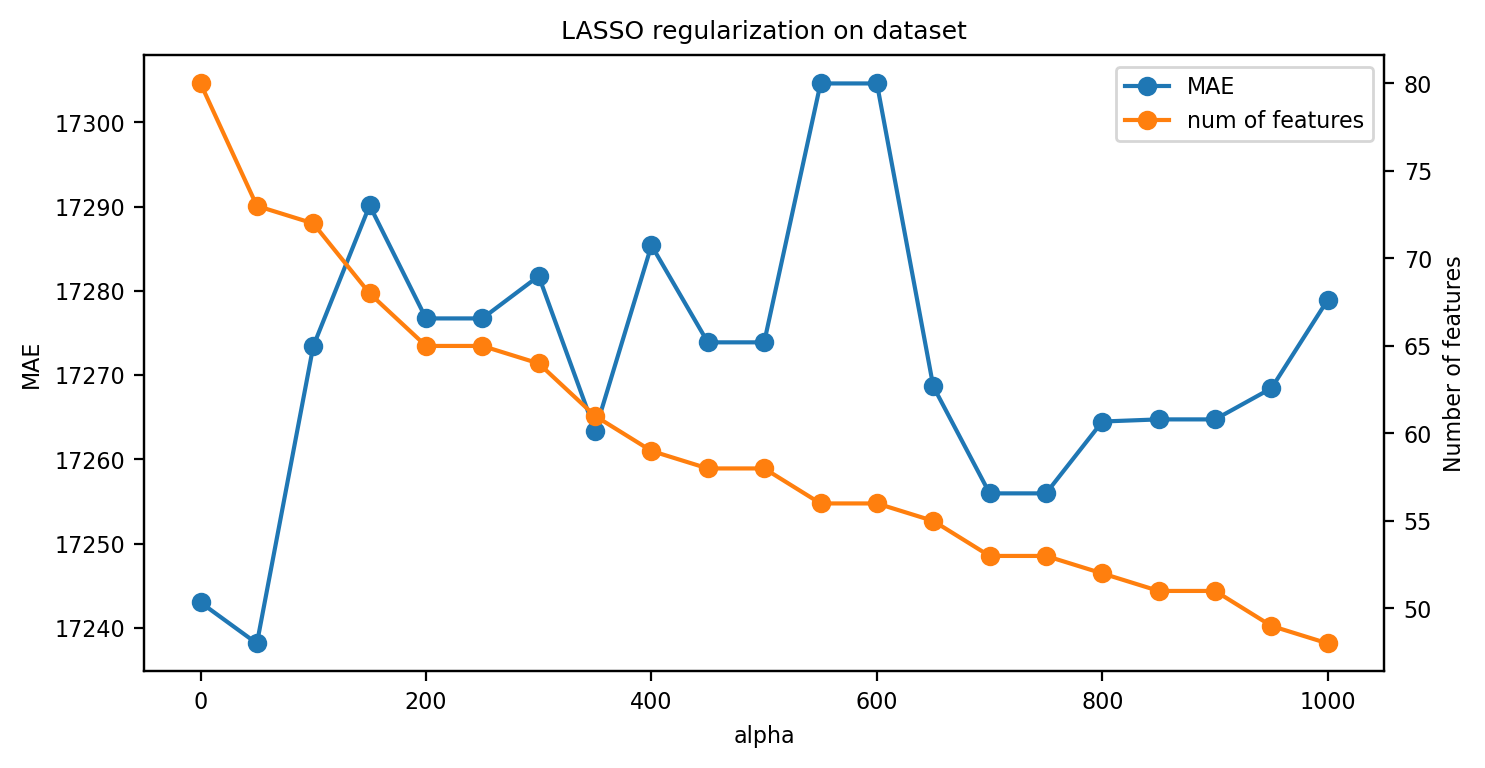

In [111]:
# Construct plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(alphas, mae, '-o', label='MAE')
ax.set_title('LASSO regularization on dataset', fontsize=9)
ax2 = ax.twinx()
ax2.plot(alphas, feature_num, '-o', c='tab:orange', label='num of features')
ax.set_ylabel('MAE', fontsize=8)
ax2.set_ylabel('Number of features', fontsize=8)
ax.set_xlabel('alpha', fontsize=8)
ax.tick_params(labelsize=8)
ax2.tick_params(labelsize=8)
fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax.transAxes, fontsize=8)
plt.show()

The value of alpha gives us almost a random-like model performance, there is no rank-ordering!

#### 2.2.2 - Random Forest Importance (Embedded Method)

We can also use a random forest ensemble to determine which features in a dataset is the most important. This relies on how the algorithm measures the information gain/entropy to build the tree[5]. Let's try it out by using a random forest regressor out of the box.

In [123]:
# Setup train/test datasets
x_train, x_test, y_train, y_test = train_test_split(X_t, Y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# Fit model
rf = RandomForestRegressor()
rf = rf.fit(x_train, y_train)
feat_imp = pd.DataFrame({'feature' : X.columns,
                         'importance': rf.feature_importances_}).sort_values('importance')
feat_imp = feat_imp.iloc[:20, :]

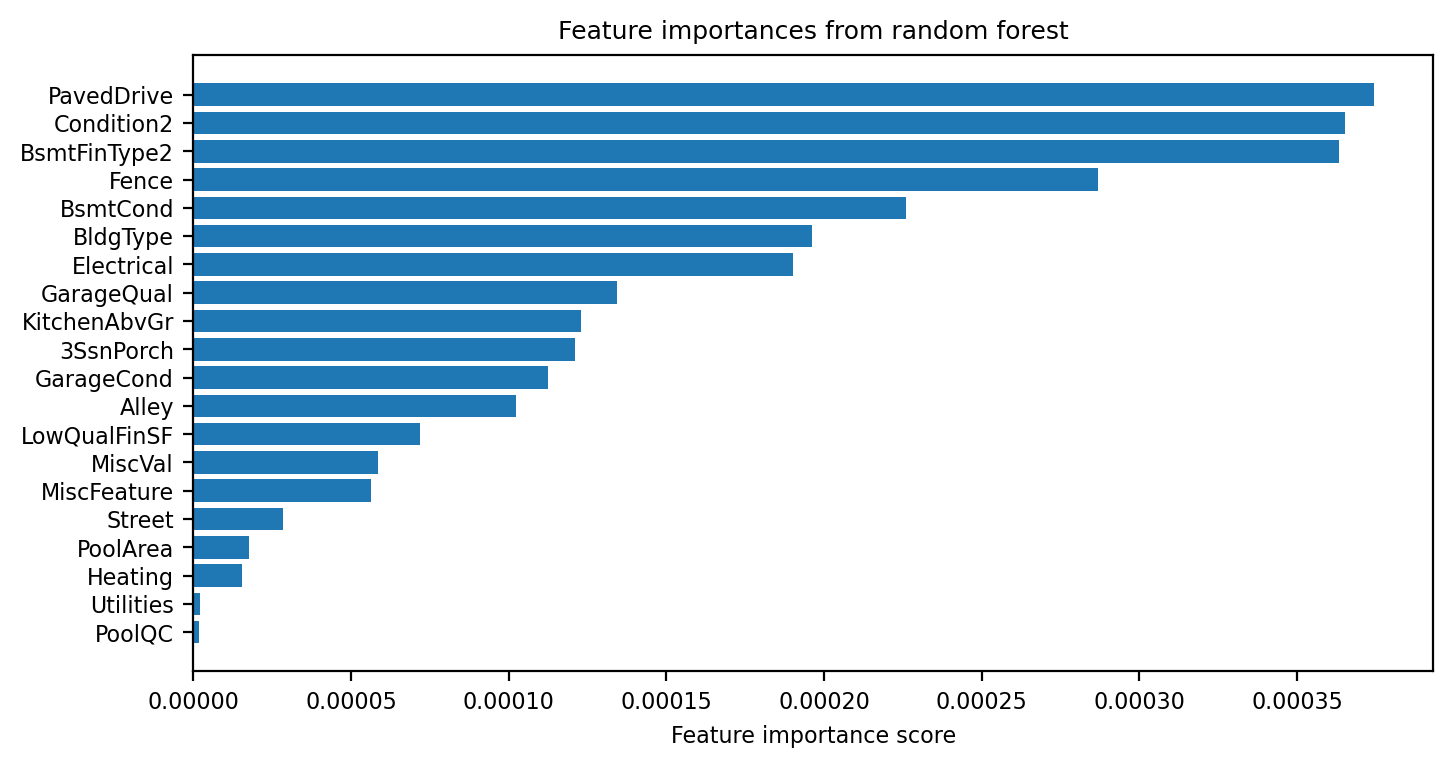

In [124]:
# Construct plot
plt.figure(figsize=(8, 4))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.title('Feature importances from random forest', fontsize=9)
plt.xlabel('Feature importance score', fontsize=8)
plt.tick_params(labelsize=8)
plt.show()

From the random forest, it can be seen that only about 18 out of 80 features really have information to contribute to the model. Let's refit our linear regression model with these 18 features and observe it's MAE performance.

In [134]:
# Get new dataset with selected features and refit the model
X_r = X[feat_imp['feature'][0:18]]
x_train, x_test, y_train, y_test = train_test_split(X_r, Y,
                                                    test_size=0.2,
                                                    shuffle=False,
                                                    random_state=1)

# Fit model
reg = LinearRegression()
reg.fit(x_train, y_train)
y_pred = reg.predict(x_train)
print(f"MAE: {mean_absolute_error(y_train, y_pred):.2f}")

MAE: 52774.17


The MAE doubled! The random forest importance is not that effective compared to the LASSO regularization method.

In the regression case study, two methods were used which is LASSO regularization and random forest importance. Both of these methods are embedded methods. For the particular dataset used in the case study, the LASSO method performed significantly better than the random forest importance method. Because embedded methods use machine learning algorithms in general, they too need to be hypertuned to ensure optimal performance on feature selection.

### <b>3 - Summary</b>

In conclusion, feature importance is an important (pun intended) technique to apply to a high dimension dataset. Doing so can enable us to achieve faster machine learning training, and a model that is less complex. There are many methods of feature importances in the industry. Primarily there are three broad categories of feature importance methods. They are filter methods, wrapper methods and embedded methods. Filter methods work by using the picking features with the best statistical value in the dataset. Wrapper methods are usually iterative and works by trying to find the feature with the best score. Lastly, embedded methods are usually machine learning algorithms that try to infer the best features available in the dataset. Each of the methods have their strengths and weaknesses and depending on the nature of the data you are working on, will or will not work best.

### <b>4 - References</b>

1. Wikipedia contributors 2023, "Feature selection", Wikipedia, The Free Encyclopedia, accessed March 6, 2023 from <https://en.wikipedia.org/wiki/Feature_selection>
2. Kaushik, Sauravkaushik8 2023, "Introduction to Feature Selection methods with an example (or how to select the right variables?)", Analytics Vidhya website, accessed March 6, 2023 from <https://www.analyticsvidhya.com/blog/2016/12/introduction-to-feature-selection-methods-with-an-example-or-how-to-select-the-right-variables/>
3. Verma, Vikas 2022, "A comprehensive guide to Feature Selection using Wrapper methods in Python", Analytics Vidhya website, accessed March 6, 2023 from <https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/>
4. Bhat, Shripad 2019, "Feature Selection: Filter method, Wrapper method and Embedded method", Data Science: Learning Machine Learning website, accessed March 6, 2023 from <https://www.datasciencesmachinelearning.com/2019/10/feature-selection-filter-method-wrapper.html>
5. Banerjee, Prashant 2021, "Comprehensive Guide on Feature Selection", Kaggle website, accessed March 7, 2023 from <https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection#4.-Embedded-Methods->